<a href="https://colab.research.google.com/github/vifirsanova/hse-python-course/blob/main/image_gen/denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Задаем априорное распределение**

Распределение Гаусса предсказывает поведение случайной величины

Если для каждой единицы, например, для одного *пикселя изображения* предсказать его величину (глубину цвета, насыщенность чёрного...) на основе нормального распределения, получится равномерный шум

In [4]:
import torch

noise = torch.randn(128, 128)
noise

tensor([[-0.1127,  0.8810,  2.4889,  ..., -0.0295, -0.3481,  0.0855],
        [ 0.0771,  0.4009,  0.6483,  ..., -0.6981,  1.0810,  0.2372],
        [ 0.1322,  2.4836,  0.7107,  ...,  1.0188, -0.4074, -0.0351],
        ...,
        [ 1.0501,  1.5680,  0.4347,  ..., -0.6502, -1.4468,  1.2592],
        [-1.0832, -0.4333, -0.4188,  ..., -2.1868, -0.1132,  0.3161],
        [-0.0112,  0.4823, -0.1994,  ..., -0.8409, -0.7187, -0.1810]])

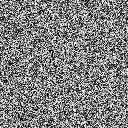

In [21]:
import torchvision.transforms as transforms

trans = transforms.ToPILImage()
out = trans(noise)
out

**2. MNIST**

In [27]:
import torchvision.datasets as datasets

# датасет MNIST для обучения модели
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

**3. Функции для нойзинга и денойзинга**

In [28]:
# генерация случайного шума:
# параметры: размер батча и количество инпутов модели скрытой диффузии
def generate_noise(batch_size, latent_size):
    return torch.randn(batch_size, latent_size)

# денойзинг: x = шум, y = изображение из датасета
def denoise_image(image, model):
    return model(image)

**4. Модель скрытой диффузии**

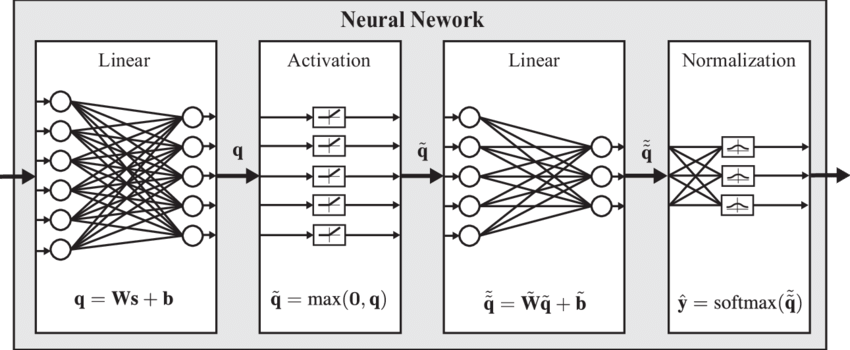

In [30]:
import torch.nn as nn

class LatentDiffusion(nn.Module):
    def __init__(self):
        super(LatentDiffusion, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 256), # аргументы: количество инпутов (latent_size)
            nn.ReLU(), # функция активации между слоями; отсекает значения < 0
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid() # выходная функция активации, значения от 0 до 1
        )

    def forward(self, z): # форвард-пасс для обратного распространения ошибки
        return self.model(z)

**5. Гиперпараметры**

Про алгоритмы оптимизации

- помогают не застрять в **локальных** минимумах
- идея любого алогритма оптимизации заключается в подроборе оптимального **шага оптимального размера** при градиентном спуске
- **Adam** - это адаптивный алгоритм, который вычисляет взвешенное среднее текущего и предыдущего значения градиентов и весов

In [32]:
import torch.optim as optim

# параметры обучения
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# инициализация модели
latent_diffusion_model = LatentDiffusion()

# алгоритм оптимизации
optimizer = optim.Adam(latent_diffusion_model.parameters(), lr=0.001)

# количество эпох
num_epochs = 20

**6. Обучаем**

In [33]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # приводим изображения к виду одномерных векторов (flatten)
        images = images.view(images.size(0), -1)

        # зашумливаем изображение
        noise = generate_noise(images.size(0), 784)  # размер матрицы = размер изображения

        # производим денойзинг: передаем шум в модель
        denoised_images = denoise_image(noise, latent_diffusion_model)

        # считаем потери
        loss = nn.MSELoss()(denoised_images, images)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # выводим отчет об обучении
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/20], Step [100/938], Loss: 0.0732
Epoch [1/20], Step [200/938], Loss: 0.0635
Epoch [1/20], Step [300/938], Loss: 0.0688
Epoch [1/20], Step [400/938], Loss: 0.0678
Epoch [1/20], Step [500/938], Loss: 0.0677
Epoch [1/20], Step [600/938], Loss: 0.0662
Epoch [1/20], Step [700/938], Loss: 0.0718
Epoch [1/20], Step [800/938], Loss: 0.0672
Epoch [1/20], Step [900/938], Loss: 0.0671
Epoch [2/20], Step [100/938], Loss: 0.0693
Epoch [2/20], Step [200/938], Loss: 0.0686
Epoch [2/20], Step [300/938], Loss: 0.0676
Epoch [2/20], Step [400/938], Loss: 0.0708
Epoch [2/20], Step [500/938], Loss: 0.0723
Epoch [2/20], Step [600/938], Loss: 0.0733
Epoch [2/20], Step [700/938], Loss: 0.0676
Epoch [2/20], Step [800/938], Loss: 0.0667
Epoch [2/20], Step [900/938], Loss: 0.0664
Epoch [3/20], Step [100/938], Loss: 0.0678
Epoch [3/20], Step [200/938], Loss: 0.0721
Epoch [3/20], Step [300/938], Loss: 0.0663
Epoch [3/20], Step [400/938], Loss: 0.0721
Epoch [3/20], Step [500/938], Loss: 0.0663
Epoch [3/20

**7. Тестируем модель**

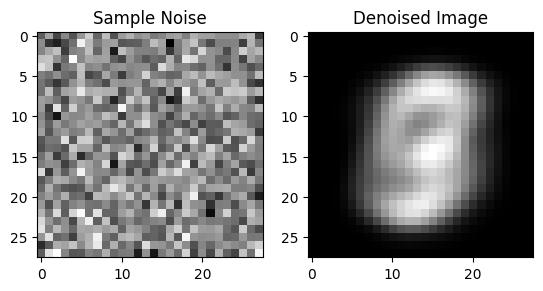

In [35]:
import matplotlib.pyplot as plt

# создаем случайный шум и передаем его обученной модели
sample_noise = generate_noise(1, 784)
sample_denoised_image = denoise_image(sample_noise, latent_diffusion_model)

# выводим на экран шум и то, что модель дешифровала с помощью обученных весов
plt.subplot(1, 2, 1)
plt.imshow(sample_noise.view(28, 28).detach().numpy(), cmap='gray')
plt.title('Sample Noise')

plt.subplot(1, 2, 2)
plt.imshow(sample_denoised_image.view(28, 28).detach().numpy(), cmap='gray')
plt.title('Denoised Image')

plt.show()